In [19]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd


input_folder = "./inputs/70TestDoors"
# output_folder = "./outputs/20220817_181813"
output_folder = "./outputs/20221012_e25b16"

# Load the trained model 
model = torch.load(output_folder + '/weights.pt')
print(output_folder + 'weights.pt')
# Set the model to evaluate mode
model.eval()

./outputs/20221012_e25b16weights.pt


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [20]:
# Read the log file using pandas into a dataframe
df = pd.read_csv(output_folder + '/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

<AxesSubplot:xlabel='epoch'>

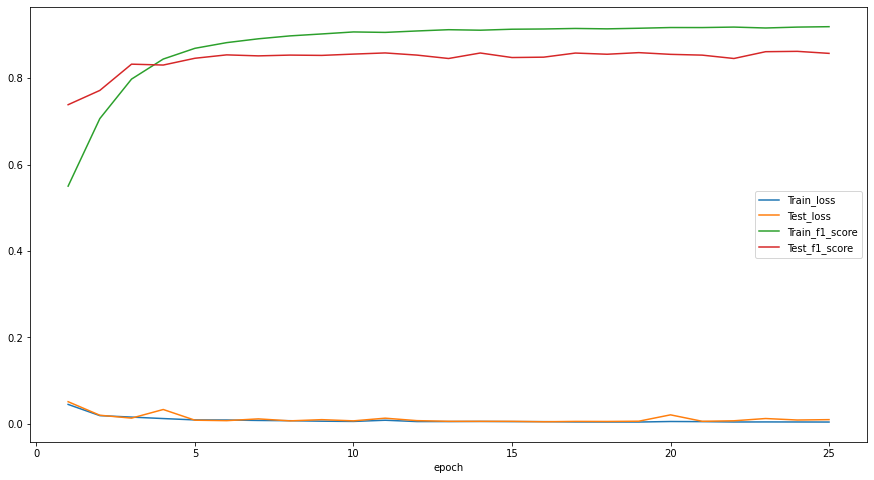

In [21]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8))

In [22]:
print(df[['Train_f1_score','Test_f1_score']].mean())

Train_f1_score    0.878432
Test_f1_score     0.844081
dtype: float64


### Sample Prediction

In [28]:
door = 'Door' + '1523'
print(f'{input_folder}/Masks/{door}.png')

# Read  a sample image from the data-set
img = cv2.imread(f'{input_folder}/Images/{door}.png').transpose(2,0,1).reshape(1,3,640,480)

with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255) #/255 makes array of numbers from 0 to 1

print(door)

./inputs/70TestDoors/Masks/Door1523.png
Door1523


(array([8.41380e+04, 2.06826e+05, 9.45400e+03, 3.71300e+03, 1.25200e+03,
        5.77000e+02, 4.27000e+02, 3.78000e+02, 3.49000e+02, 8.60000e+01]),
 array([-0.06415163, -0.00287375,  0.05840413,  0.119682  ,  0.18095988,
         0.24223775,  0.30351564,  0.3647935 ,  0.42607138,  0.48734927,
         0.54862714], dtype=float32),
 <BarContainer object of 10 artists>)

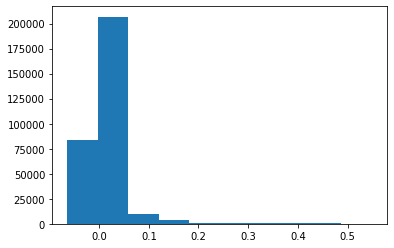

In [29]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a['out'].data.cpu().numpy().flatten())

In [30]:
import numpy as np
median = np.median(a['out'].data.cpu().numpy().flatten())
print(median)
mean = a['out'].data.cpu().numpy().flatten().mean()
print(mean)

0.00239902
0.010469723


(-0.5, 479.5, 639.5, -0.5)

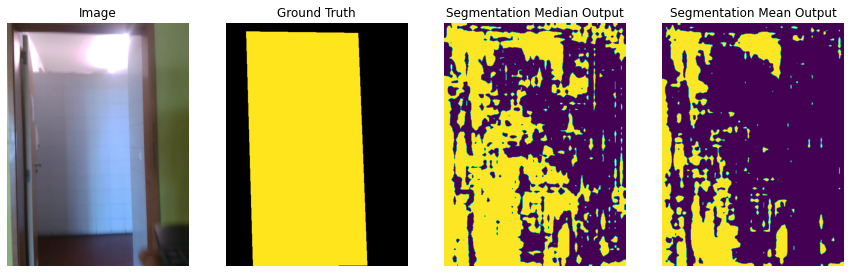

In [31]:
from PIL import Image
# Plot the input image, ground truth and the predicted output
rgb_image = cv2.cvtColor(cv2.imread(f'{input_folder}/Images/{door}.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread(f'{input_folder}/Masks/{door}.png')

plt.figure(figsize=(15,10))

plt.subplot(141)
plt.imshow(rgb_image)
plt.title('Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(143)


median_img_array = (a['out'].cpu().detach().numpy()[0][0]> median)
median_img_object = Image.fromarray(median_img_array* np.uint8(255))
plt.imshow(median_img_array)
plt.title('Segmentation Median Output')
plt.axis('off')

plt.subplot(144)
# plt.imshow((a['out'][0].argmax(0).byte().cpu().numpy()> median)* np.uint8(255))
plt.imshow(a['out'].cpu().detach().numpy()[0][0]> mean)
plt.title('Segmentation Mean Output')
plt.axis('off')
# # plt.savefig('./DoorsMediumExp/SegmentationOutput.png',bbox_inches='tight')

Door1523
69.61680176860722


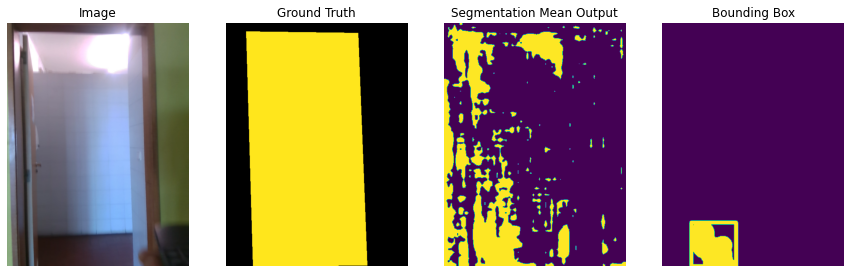

In [32]:
from PIL import Image


# Read  a sample image from the data-set
img = cv2.imread(f'{input_folder}/Images/{door}.png').transpose(2,0,1).reshape(1,3,640,480)

with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255) #/255 makes array of numbers from 0 to 1

print(door)

# Plot the input image, ground truth and the predicted output
rgb_image = cv2.cvtColor(cv2.imread(f'{input_folder}/Images/{door}.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread(f'{input_folder}/Masks/{door}.png')

plt.figure(figsize=(15,10))

plt.subplot(141)
plt.imshow(rgb_image)
plt.title('Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(143)
# plt.imshow((a['out'][0].argmax(0).byte().cpu().numpy()> median)* np.uint8(255))
mean_img_array = a['out'].cpu().detach().numpy()[0][0]> mean
plt.imshow(mean_img_array)
plt.title('Segmentation Mean Output')
plt.axis('off')

# plt.imshow((a['out'][0].argmax(0).byte().cpu().numpy()> median)* np.uint8(255))
# plt.imshow(a['out'].cpu().detach().numpy()[0][0]> mean)

#https://stackoverflow.com/questions/56589691/how-to-leave-only-the-largest-blob-in-an-image 
# Read image as black and white instead of true or false
input_img = mean_img_array * np.uint8(255)
# Generate intermediate image;
inter = cv2.morphologyEx(input_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
inter = cv2.morphologyEx(input_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50)))

# Find largest contour in intermediate image
contours, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
biggest_c = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(biggest_c)

# Output
out = np.zeros(inter.shape, np.uint8)
out = cv2.bitwise_and(input_img, out)
# draw the biggest contour (c) in green
cv2.drawContours(out, [biggest_c], -1, 255, cv2.FILLED)
cv2.rectangle(out,(x,y),(x+w,y+h),255,10)

rectangle_area = w*h
blob_area = cv2.contourArea(biggest_c)

confidence = (blob_area/rectangle_area) * 100
print(confidence)

plt.subplot(144)
plt.title('Bounding Box')
plt.axis('off')
plt.imshow(out)
plt.savefig(f'./inputs/testing/{door}.png',bbox_inches='tight')


44.385072457572775


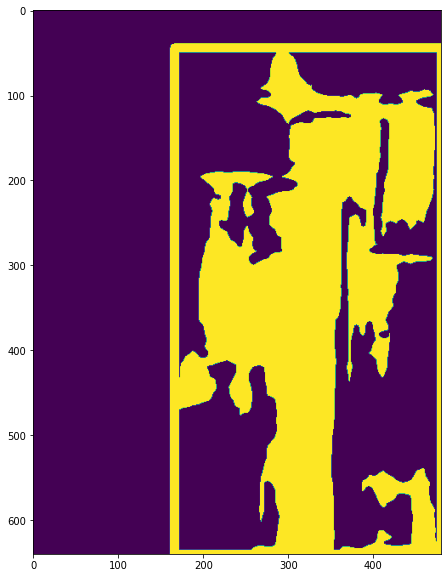

In [15]:
#https://stackoverflow.com/questions/56589691/how-to-leave-only-the-largest-blob-in-an-image 
# Read image as black and white instead of true or false
input_img = median_img_array * np.uint8(255)
# Generate intermediate image;
inter = cv2.morphologyEx(input_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
# inter = cv2.morphologyEx(input_img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# Find largest contour in intermediate image
contours, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
biggest_c = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(biggest_c)

# Output
out = np.zeros(inter.shape, np.uint8)
out = cv2.bitwise_and(input_img, out)
# draw the biggest contour (c) in green
cv2.drawContours(out, [biggest_c], -1, 255, cv2.FILLED)
cv2.rectangle(out,(x,y),(x+w,y+h),255,10)

rectangle_area = w*h
blob_area = cv2.contourArea(biggest_c)

confidence = (blob_area/rectangle_area) * 100
print(confidence)
plt.figure(figsize=(15,10))
plt.imshow(out)
# cv2.imshow('out', out)
# cv2.waitKey(0)